In [30]:
%run './functions.ipynb'

In [31]:
meta_df = pd.read_excel(patietns_meta_data)
intensity_meta = load_intensity_meta_data(Path(direcroy_path)/Path(PREPROCESSED_FP_INTENSITY),'Gene names')
intensity_df = pd.read_csv(Path(direcroy_path)/Path(PREPROCESSED_FP_INTENSITY))
sample_annotation_df = pd.read_csv('/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_paper_cohort_230626_final.csv')
RNA_failed_patients = meta_df['Sample name'][meta_df['RNA QC issue'] == 'x'].tolist()

reading /media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT/preprocessed_fp.csv
Intensity meta_data loaded


In [13]:
sample_annotation_df

Sample name   Cohort Program   Entity Histologic Subtype  \
0      I007-031-108742  Sarcoma  INFORM  Sarcoma   Rhabdomyosarcoma   
1       I043-005-95540  Sarcoma  INFORM  Sarcoma   Rhabdomyosarcoma   
2     I007-020-1007541  Sarcoma  INFORM  Sarcoma   Rhabdomyosarcoma   
3      I007-039-130734  Sarcoma  INFORM  Sarcoma   Rhabdomyosarcoma   
4       I043-001-80842  Sarcoma  INFORM  Sarcoma   Rhabdomyosarcoma   
..                 ...      ...     ...      ...                ...   
631  H021-ABQZJ9-M1-Q1  Sarcoma  MASTER    other              other   
632  H021-AC1JA4-M1-Q1  Sarcoma  MASTER    other              other   
633  H021-B8Y6CY-M5-Q1  Sarcoma  MASTER    other              other   
634  H021-KMYMSJ-M1-Q1  Sarcoma  MASTER    other              other   
635  H021-SE8CGE-T2-Q1  Sarcoma  MASTER    other              other   

     Batch Name  TMT Channel      QC Replicate  Material issue  
0             1            1  passed       NaN             NaN  
1             1            2  passed       NaN             NaN  
2             1            3  passed       NaN             NaN  
3             1            4  passed       NaN             NaN  
4             1            5  passed       NaN             NaN  
..          ...          ...     ...       ...             ...  
631         114            4  passed       NaN             NaN  
632         114            5  passed       NaN             NaN  
633         114            6  passed       NaN             NaN  
634         114            7  passed       NaN             NaN  
635         114            8  passed       NaN             NaN  

[636 rows x 10 columns]

In [41]:
def getProteinListPerBatch(batchNo,sample_annotation,df_intensity):
    """ Gets the list of the proteins for one batch as a dataFrame"""
    df_intensity = df_intensity.set_index('Gene names')
    list_patients_batch = list(sample_annotation['Sample name'][sample_annotation['Batch Name'].astype(str) == str(batchNo)])
    list_patients_batch = intersection(list_patients_batch,df_intensity.columns)


    batch_df = df_intensity[list_patients_batch]
    batch_df = batch_df.dropna()
    batch_proteins = pd.DataFrame(list(set(batch_df.index)))
    batch_proteins.columns = ['sample']
    batch_proteins['group'] = batchNo
    return batch_proteins




In [69]:
all_batches = sample_annotation_df['Batch Name'].unique()
batch_occurence = [getProteinListPerBatch(x,sample_annotation_df,intensity_df) for x in all_batches]
batch_occurence_df = pd.concat(batch_occurence)
counts_per_batch = batch_occurence_df.groupby('sample')['group'].count()


In [86]:
proteins_selected = counts_per_batch.index[counts_per_batch > 10 ].to_list() # Occurence in at least 10 batches

# Correlation with  all Transcript FPKM


In [70]:
#  full proteome_z_scores
Z_SCORES_df_proteome = pd.read_csv(Path(direcroy_path)/Path(Z_SCORES_PATH),sep='\t')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.set_index('Gene names')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.filter(regex=REGEX)
# there is no protein grouping at transcriptome level we unnest the protein groups also for protein data
Z_SCORES_df_proteome = unnest_proteingroups(Z_SCORES_df_proteome)
Z_SCORES_df_proteome.columns = Z_SCORES_df_proteome.columns.str.replace('zscore_','')

# transcriptome_z_scores
transcripts_z_scores = pd.read_csv(transcripts_path)
transcripts_z_scores = transcripts_z_scores.set_index('genes')
transcripts_z_scores =  transcripts_z_scores.filter(regex=Z_SCORE_REGEX)
transcripts_z_scores.columns = transcripts_z_scores.columns.str.replace(' Z-score','')

protein_list = intersection(transcripts_z_scores.index.tolist(),Z_SCORES_df_proteome.index.tolist())
intersecting_patients = intersection(transcripts_z_scores.columns.tolist(),Z_SCORES_df_proteome.columns.tolist())

intersecting_patients = [x for x in intersecting_patients if x not in  RNA_failed_patients]
Z_SCORES_df_proteome = Z_SCORES_df_proteome[intersecting_patients]
transcripts_z_scores = transcripts_z_scores[intersecting_patients]
correlation_df = pd.DataFrame(protein_list,columns=['protein'])
correlation_df['correlation'] = None
correlation_df['num_patients'] = None
correlation_df['median_peptides'] = None

for i in range(len(correlation_df)):
    protein_correlaiton, num_patientes = get_correlation(correlation_df['protein'][i],Z_SCORES_df_proteome,transcripts_z_scores)
    correlation_df['correlation'][i] = protein_correlaiton
    correlation_df['num_patients'][i] = num_patientes
    try:
        correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
    except:
        print('no median of the peptides was calculated for this protein')
correlation_df = correlation_df.set_index('protein')

basket_annotation_df = pd.read_excel(basket_annotation_path)
correlation_df['basket_annotation'] = ''
for i in range(len(correlation_df)):
    correlation_df['basket_annotation'][i] = ';'.join(basket_annotation_df['BASKET'][basket_annotation_df["GENE NAME"].isin([correlation_df.index[i]])].unique().tolist())

correlation_df = correlation_df.dropna(subset='correlation')
correlation_df.to_excel('~/Desktop/correlation_all_proteins_RNA_failed_removed.xlsx')


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykerne

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein
no median of the peptides was calculated for this protein


/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i]).median()
/tmp/ipykernel_250876/4195691990.py:100: FutureWarning: The default value of regex will change from True to False in a future version.
  premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','')
/tmp/ipykernel_250876/2963202758.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version th

no median of the peptides was calculated for this protein


In [87]:
correlation_df = correlation_df[correlation_df.index.isin(proteins_selected)]

In [88]:
len(correlation_df)

3260

# Histogram

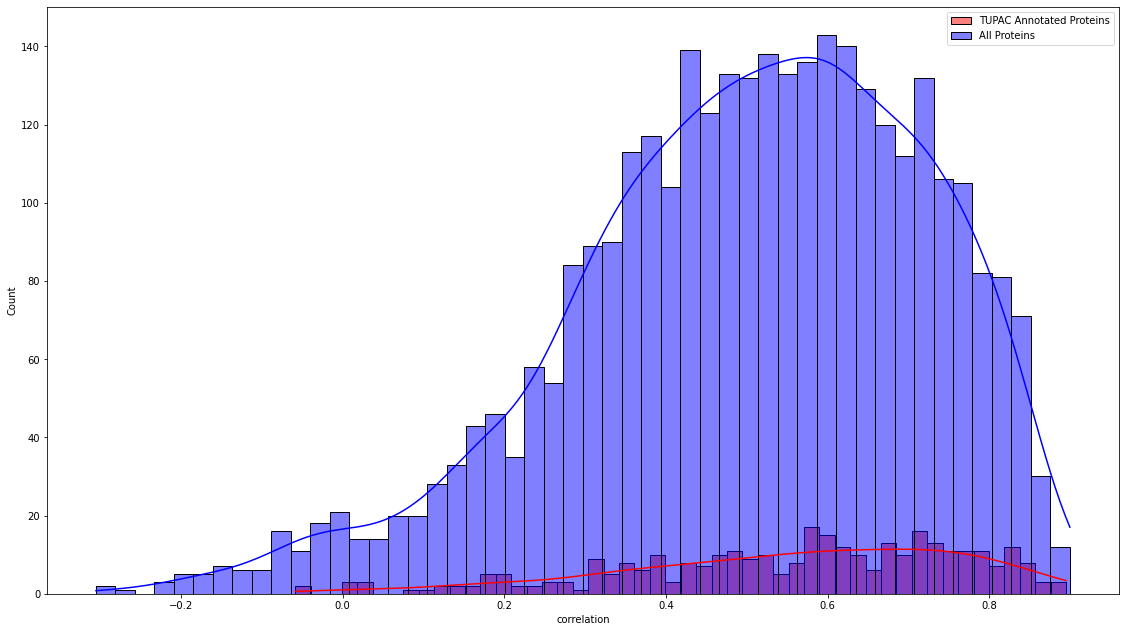

In [90]:
basket_correlation_df = correlation_df[correlation_df['basket_annotation'] != '']
#import plotly.express as px
#fig = px.histogram(all_correlation_df, x="correlation",color='type',nbins=100,histnorm='probability density')
#fig.show()
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(19.20,10.80))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
#sns.set(style="darkgrid")
#fig, axs = plt.subplots(1, 2, figsize=(7, 7))
#sns.histplot(data=correlation_df_lysates, x="correlation",binwidth=0.1, kde=True, color="red", ax=axs[0],bins=1000)
#sns.histplot(data=correlation_df, x="correlation", kde=True, color="blue", ax=axs[1],bins=1000)
correlation_df = correlation_df.dropna(subset='correlation')
basket_correlation_df = basket_correlation_df.dropna(subset='correlation')
num_bins = 50
sns.histplot(data=basket_correlation_df, x="correlation",label="TUPAC Annotated Proteins",  kde=True,color="red",bins=num_bins) # only for the lysates
sns.histplot(data=correlation_df, x="correlation",label="All Proteins", kde=True, color="blue",bins=num_bins)  # for all patients
#plt.axvline(2.8, 0,0.17)
plt.legend() 
#plt.show()
plt.savefig(f'/home/amir/Desktop/Protein_Transcripts_correlation_TUPAC_vs_allproteins_batch_cutoff_occurence_all_batches.svg',dpi=300)

